<a href="https://colab.research.google.com/github/rociotarda/TP1---Datos/blob/main/Analisis_exploratorio_Nico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
uploaded = files.upload()

Saving train_values.csv to train_values.csv
Saving train_labels.csv to train_labels.csv


In [3]:
pip install squarify

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import squarify
  
train_labels = pd.read_csv(io.BytesIO(uploaded['train_labels.csv']))
train_labels.head()

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3
3,590882,2
4,201944,3


In [5]:
train_values = pd.read_csv(io.BytesIO(uploaded['train_values.csv']))
train_values.head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
5,333020,8,558,6089,2,10,9,5,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,1,1,0,0,0,0,0,0,0,0,0
6,728451,9,475,12066,2,25,3,4,n,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
7,475515,20,323,12236,2,0,8,6,t,w,q,v,x,s,u,0,0,0,0,0,1,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
8,441126,0,757,7219,2,15,8,6,t,r,q,f,q,s,d,0,1,0,0,0,0,1,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
9,989500,26,886,994,1,0,13,4,t,i,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train_values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   building_id                             260601 non-null  int64 
 1   geo_level_1_id                          260601 non-null  int64 
 2   geo_level_2_id                          260601 non-null  int64 
 3   geo_level_3_id                          260601 non-null  int64 
 4   count_floors_pre_eq                     260601 non-null  int64 
 5   age                                     260601 non-null  int64 
 6   area_percentage                         260601 non-null  int64 
 7   height_percentage                       260601 non-null  int64 
 8   land_surface_condition                  260601 non-null  object
 9   foundation_type                         260601 non-null  object
 10  roof_type                               260601 non-null 

# Nivel de daño

In [69]:
train_labels['damage_grade'].value_counts().sort_values(ascending=True)

1     25124
3     87218
2    148259
Name: damage_grade, dtype: int64

Vemos que el daño realizado puede ser de nivel 1, 2, 3.
- El nivel 1 representa un daño menor
- El nivel 2 representa un daño mediano
- El nivel 3 representa un daño completo

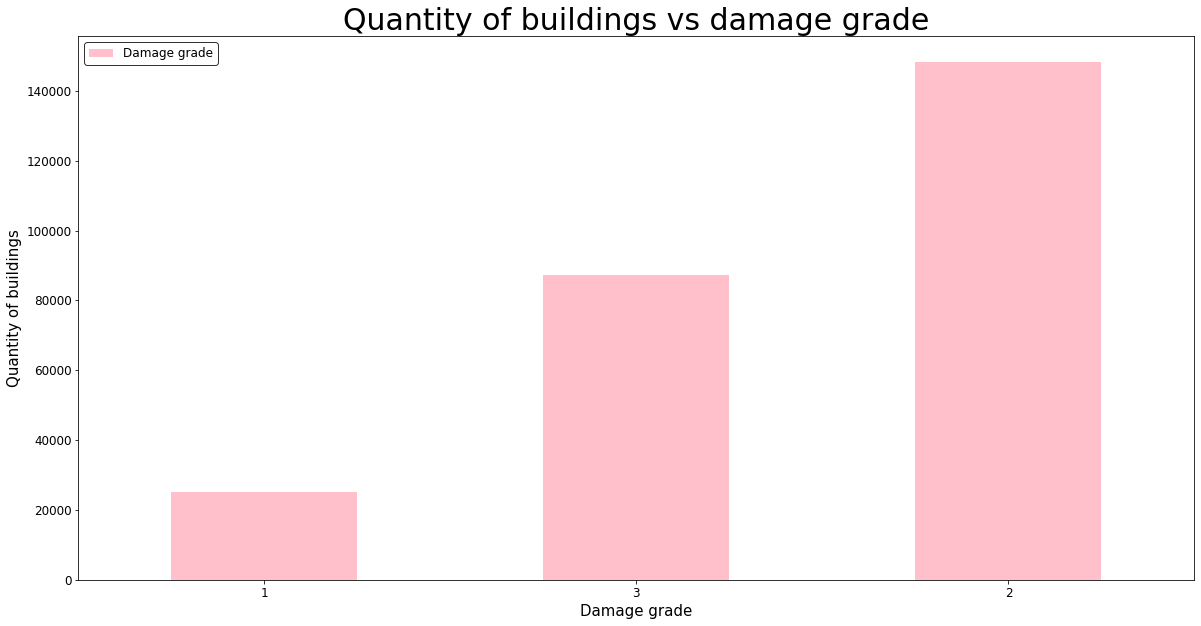

In [76]:
plot=train_labels['damage_grade'].value_counts().sort_values(ascending=True).plot(kind='bar',color=['pink'], figsize=(20,10))
plt.xlabel("Damage grade", size=15)
plt.ylabel("Quantity of buildings", size=15)
plt.legend(fancybox=True)
plt.xticks(rotation=0)
plt.title("Quantity of buildings vs damage grade", size = 30)
leyenda=plt.legend(['Damage grade'],frameon=True,facecolor='white',edgecolor='black')

# Registros "duplicados"

Veamos si hay registros duplicados, sin tener en cuenta el building_id

In [7]:
train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].shape[0]

28544

In [8]:
train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].head(10)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
12,444381,12,335,8167,2,15,6,5,t,r,n,x,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
18,354011,26,1401,3904,1,20,12,3,t,u,n,v,j,s,d,0,0,0,0,0,1,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
48,987864,10,1097,399,2,20,7,4,t,r,q,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
59,302199,13,221,7919,3,20,7,6,t,r,n,f,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
71,708530,26,39,10795,1,0,17,3,t,i,x,v,j,s,d,0,0,0,0,0,0,0,0,0,1,0,v,1,0,0,0,0,0,0,0,0,0,0,0
76,425720,20,136,4769,2,0,5,7,t,w,q,f,x,s,d,0,0,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
103,96470,4,474,11771,2,10,8,7,n,r,n,z,q,s,d,0,1,1,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
105,820425,3,574,4163,3,30,6,8,t,r,n,f,q,t,d,1,0,0,0,1,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


De un total de 260601 registros, vemos que hay 28544 que son duplicados. Veamos si alguno de ellos es debido a que hay registros duplicados con building_id

In [9]:
len(set(train_values[train_values.duplicated(subset=list(train_values.columns)[1:],keep=False)].building_id))

28544

Tambien lo podemos ver con un value_counts de la columna:

In [10]:
train_values['building_id'].value_counts()

1052670    1
847304     1
368102     1
729986     1
900578     1
          ..
56753      1
946311     1
15789      1
13740      1
524288     1
Name: building_id, Length: 260601, dtype: int64

Esto quiere decir que estos registros "duplicados" comparten todas las columnas, pero parecería ser que no tienen el mismo building_id. Lo que puede suceder es que son edificios "residenciales" que se construyeron en el mismo lugar, con el mismo tamaño y de los mismos materiales de construcción. Veamos por ejemplo la cantidad de registros por geo_level_3_id:

In [11]:
train_values['geo_level_3_id'].value_counts()

633      651
9133     647
621      530
11246    470
2005     466
        ... 
6095       1
3599       1
7886       1
9994       1
11851      1
Name: geo_level_3_id, Length: 11595, dtype: int64

Viendo anteriormente alguno de los registros que parecen duplicados, agarremos el geo_level_3 = 2812

In [12]:
buildings_geo_3_2812 = train_values[train_values['geo_level_3_id']==2812]
buildings_geo_3_2812.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
17093,265547,8,900,2812,2,10,7,7,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
34007,674412,8,900,2812,2,15,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
51151,988427,8,900,2812,2,10,5,6,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
52872,111255,8,900,2812,3,15,11,8,o,r,n,x,q,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


In [13]:
buildings_geo_3_conditions = buildings_geo_3_2812.loc[(buildings_geo_3_2812['position']=='s') & (buildings_geo_3_2812['height_percentage']==7) & (buildings_geo_3_2812['age']==10), :]
buildings_geo_3_conditions.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
205258,938572,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


Vemos que hay dos registros identicos, con la diferencia que tienen un building_id distinto. El significado de esto puede ser lo mencionado anteriormente, que simplemente al ser residenciales y están ubicados en el mismo geo_level_3, son edificios que se contruyeron de la misma forma, y con el mismo fin. Borrarlos sería un error, ya que perderíamos un 10% de la información, siendo diferentes registros.

Otro ejemplo puede ser el siguiente, donde el *building_id=590882* es igual a *building_id=1006803*

In [14]:
building_duplicated_2 = train_values.loc[(train_values['position']=='s') & (train_values['height_percentage']==5) & (train_values['age']==10) & (train_values['geo_level_3_id']==10694) & (train_values['other_floor_type']=='x'), :]
building_duplicated_2

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
138406,614984,22,418,10694,2,10,11,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0
142884,1006803,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0


# Edad de los edificios

In [15]:
train_values['age'].value_counts()

10     38896
15     36010
5      33697
20     32182
0      26041
25     24366
30     18028
35     10710
40     10559
50      7257
45      4711
60      3612
80      3055
55      2033
70      1975
995     1390
100     1364
65      1123
90      1085
85       847
75       512
95       414
120      180
150      142
200      106
110      100
105       89
125       37
115       21
140        9
130        9
180        7
160        6
170        6
175        5
135        5
145        3
190        3
195        2
165        2
155        1
185        1
Name: age, dtype: int64

A primera vista llama la atención que hay 1390 edificios que destruidos con 995 años de antiguedad. Haciendo una investigación acerca de Nepal, y más en concreto en el sudeste asiático, vemos que la historia se remonta a los años A.C., por lo que las construcciones de hace 1000 años, si bien llaman la atención son más que factibles.

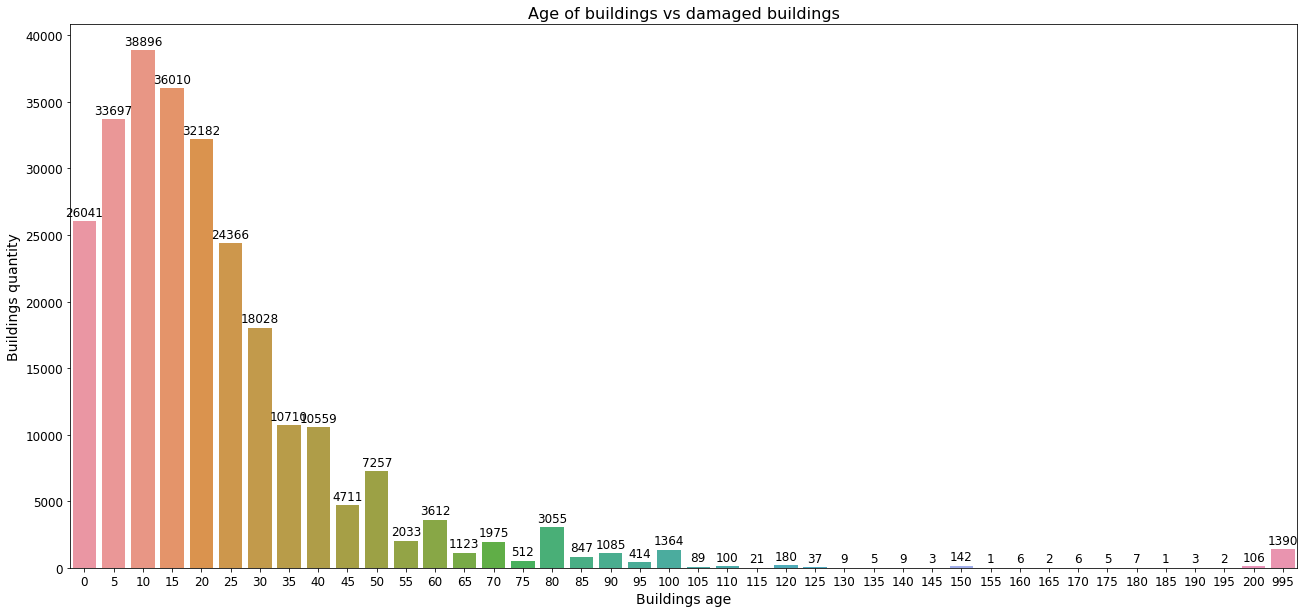

In [53]:
target = train_values['age'].value_counts()
plt.subplots(figsize=(22,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Age of buildings vs damaged buildings",fontsize=16)
grafico.set_ylabel("Buildings quantity",fontsize=14)
grafico.set_xlabel("Buildings age",fontsize=14);


Podemos tomar como hipotesis que al haber estos 995 edificios antiguos, se entienden que son construcciones antiguas, como por ejemplo templos. Cuando se generaron los datos, se habrá tomado la decisión de capear todos estos edificios como que tenian 995 años. Igualmente, tiene sentido que hayan solamente 1300 edificios con esa antiguedad destruido, comparado a la cantidad de editicios mas "recientes" que fueron destruidos.

Tambien podemos tomar como hipotesis lo mismo para la antiguedad de 200 años, ya que se habrá decidido capear a el resto de edificios de mayor antiguedad, como 205, 210, etc... hacia los 200 años.

Ahora veamos la comparación entre las antiguedades y el nivel de daño, no solo la cantidad que fueron dañados.

In [78]:
damaged_buildings = train_values.merge(train_labels)
damaged_buildings.head(5)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


In [144]:
damaged_buildings_by_age = damaged_buildings.groupby(['age', 'damage_grade']).agg({'damage_grade':['count']})
damaged_buildings_by_age
level0 = damaged_buildings_by_age.columns.get_level_values(0)
level1 = damaged_buildings_by_age.columns.get_level_values(1)
damaged_buildings_by_age.columns = level0 + '_' + level1
damaged_buildings_by_age.reset_index(inplace=True)
damaged_buildings_by_age.head()

,age,damage_grade,damage_grade_count
0,0,1,7213
1,0,2,12721
2,0,3,6107
3,5,1,5590
4,5,2,19030


In [140]:
damaged_buildings_age_pivot = damaged_buildings_by_age.pivot(index='age', columns='damage_grade', values='damage_grade_count')

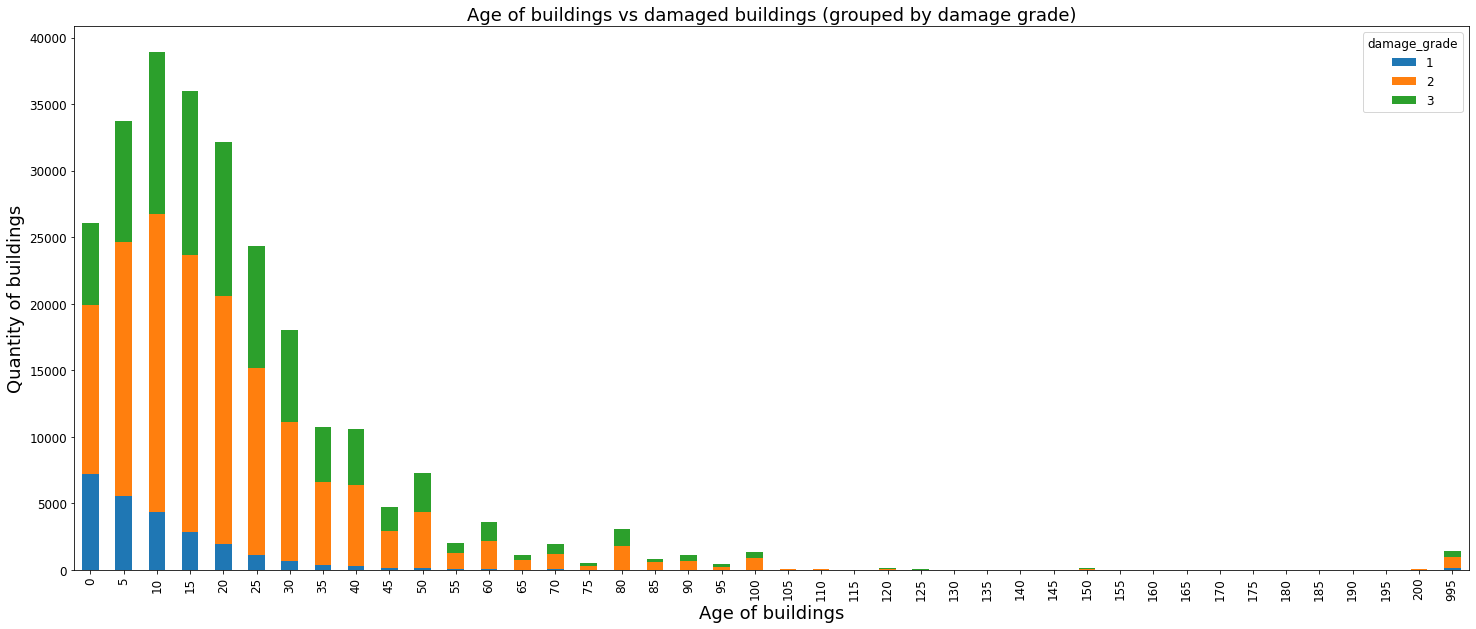

In [141]:
plot = damaged_buildings_age_pivot.plot.bar(stacked=True, figsize=(25,10))
plot.set_title("Age of buildings vs damaged buildings (grouped by damage grade)", fontsize=18)
plot.set_ylabel("Quantity of buildings", fontsize=18);
plot.set_xlabel("Age of buildings", fontsize=18);

Se puede observar que en general para todas las antiguedades de los edificios, la mayoría del daño provocado fue de nivel 2, seguido por el nivel 3 (destrucción completa)

# Cantidad de pisos

Veamos como se comportaron los edificios teniendo en cuenta la cantidad de pisos. Luego volveremos a retomar y lo compararemos con la antiguedad de los mismos.

In [17]:
damaged_by_floor = train_values['count_floors_pre_eq'].value_counts()
damaged_by_floor.to_list()
floors = train_values['count_floors_pre_eq'].value_counts().index

In [18]:
damage = {'damage': damaged_by_floor, 'floors': floors}
damage_df = pd.DataFrame(data=damage)
damage_df

,damage,floors
2,156623,2
3,55617,3
1,40441,1
4,5424,4
5,2246,5
6,209,6
7,39,7
9,1,9
8,1,8


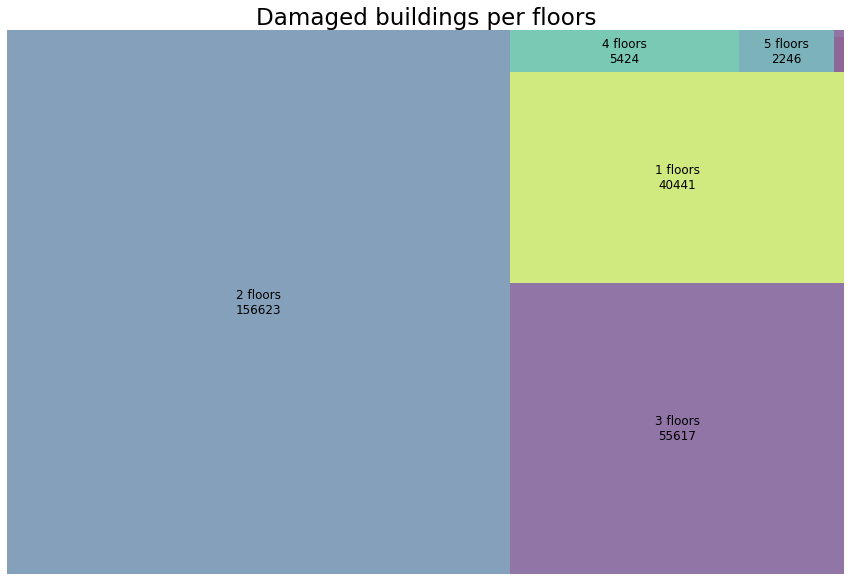

In [138]:
labels = [f'{floors} floors\n{damage}' for damage, floors in zip(damage_df.damage, damage_df.floors)]

plt.figure(figsize=(15, 10))
plt.rc('font', size=12)
squarify.plot(sizes=damaged_by_floor, label=labels[:5], alpha=0.6)

plt.title("Damaged buildings per floors",fontsize=23)
plt.axis('off')
plt.show()

Con este gráfico de heatmap podemos tener una noción de la proporción de los edificios dependiendo de la cantidad de pisos. Únicamente se muestran los labels para los 5 pisos más destruidos ya que si no se pisarían los labels en los pisos menores y no se apreciarían bien los datos.

Conociendo la cantidad de edificios que fueron destruidos por cantidad de pisos, veamos ahora como se distribuye el nivel de daño en cada uno de ellos

In [149]:
damaged_buildings_by_floor = damaged_buildings.groupby(['count_floors_pre_eq', 'damage_grade']).agg({'damage_grade':['count']})
damaged_buildings_by_floor
level0 = damaged_buildings_by_floor.columns.get_level_values(0)
level1 = damaged_buildings_by_floor.columns.get_level_values(1)
damaged_buildings_by_floor.columns = level0 + '_' + level1
damaged_buildings_by_floor.reset_index(inplace=True)
damaged_buildings_by_floor.head()

,count_floors_pre_eq,damage_grade,damage_grade_count
0,1,1,8969
1,1,2,20798
2,1,3,10674
3,2,1,12593
4,2,2,93968


In [150]:
damaged_buildings_floors_pivot = damaged_buildings_by_floor.pivot(index='count_floors_pre_eq', columns='damage_grade', values='damage_grade_count')

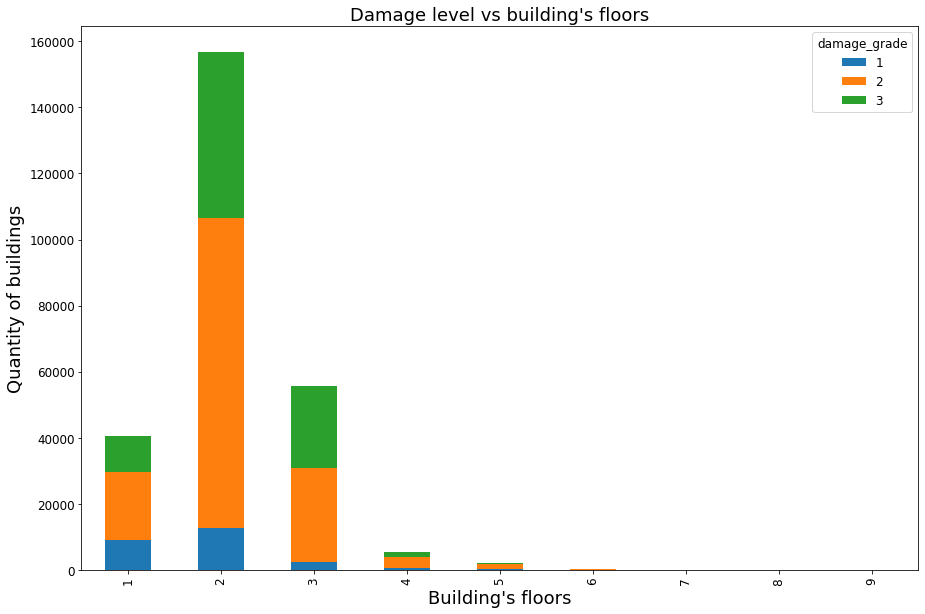

In [154]:
plot_damage_by_floors = damaged_buildings_floors_pivot.plot.bar(stacked=True, figsize=(15,10))
plot_damage_by_floors.set_title("Damage level vs building's floors", fontsize=18)
plot_damage_by_floors.set_ylabel("Quantity of buildings", fontsize=18);
plot_damage_by_floors.set_xlabel("Building's floors", fontsize=18);

Se puede observar que en general para todos los pisos, los edificios sufrieron más daños de nivel 2, y en segunda medida del nivel 3 (es decir que fueron completamente destruidos)

- Tomando los edificios con el mayor "piso" que fueron destruidos, es decir 2 pisos, veamos tambien que sucede con la antiguedad de ellos:

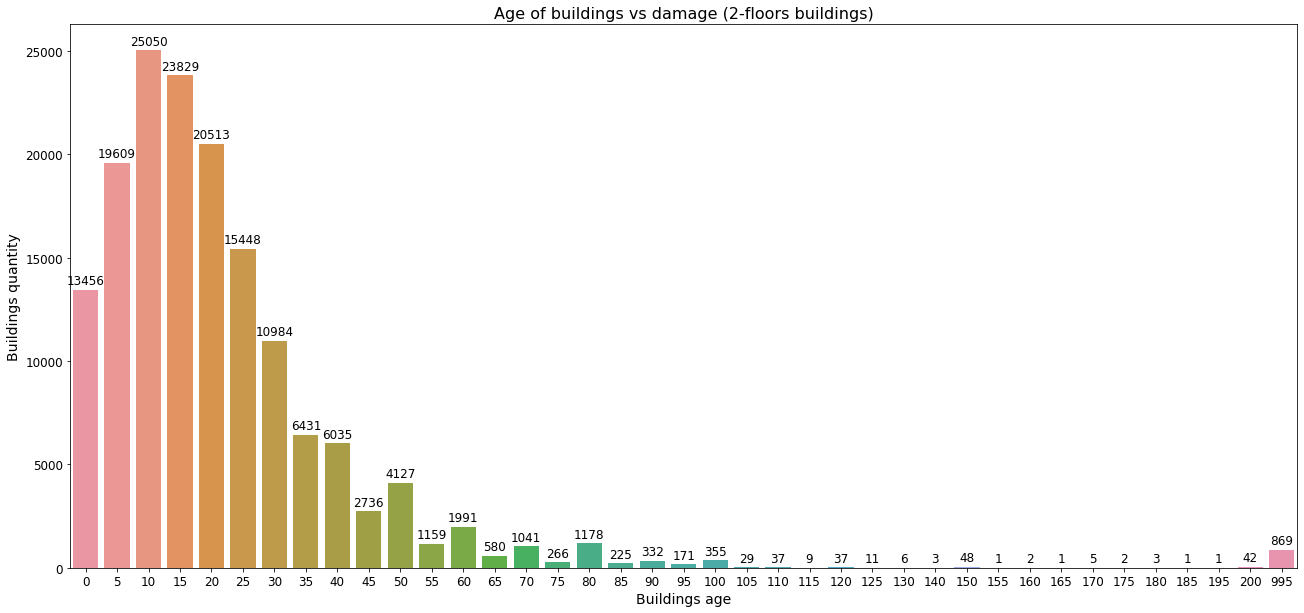

In [52]:
damaged_two_floors = train_values.loc[train_values['count_floors_pre_eq']==2, :]
target = damaged_two_floors['age'].value_counts()
plt.subplots(figsize=(22,10))
grafico=sns.barplot(y=target.values,x=target.index,orient='v')
for p in grafico.patches:
    grafico.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
grafico.set_title("Age of buildings vs damage (2-floors buildings)",fontsize=16)
grafico.set_ylabel("Buildings quantity",fontsize=14)
grafico.set_xlabel("Buildings age",fontsize=14);

A grandes rasgos se puede observar que conserva la misma relación que el daño total, sin importar la cantidad de pisos. Los edificios de 10 años de antiguedad fueron los más dañados.

De la misma forma que en el inciso anterior, podemos ver para los edificios de 2 pisos, como se comporta el nivel de daño para cada uno de ellos

In [135]:
buildings_2_floors = damaged_two_floors.merge(train_labels).groupby(['age', 'damage_grade']).agg({'damage_grade':['count']})
buildings_2_floors

level0 = buildings_2_floors.columns.get_level_values(0)
level1 = buildings_2_floors.columns.get_level_values(1)
buildings_2_floors.columns = level0 + '_' + level1
buildings_2_floors.reset_index(inplace=True)
buildings_2_floors

,age,damage_grade,damage_grade_count
0,0,1,2589
1,0,2,7400
2,0,3,3467
3,5,1,2530
4,5,2,11765
...,...,...,...
94,200,2,20
95,200,3,20
96,995,1,121
97,995,2,509


In [136]:
damaged_buildings_2_floors_pivot = buildings_2_floors.pivot(index='age', columns='damage_grade', values='damage_grade_count')

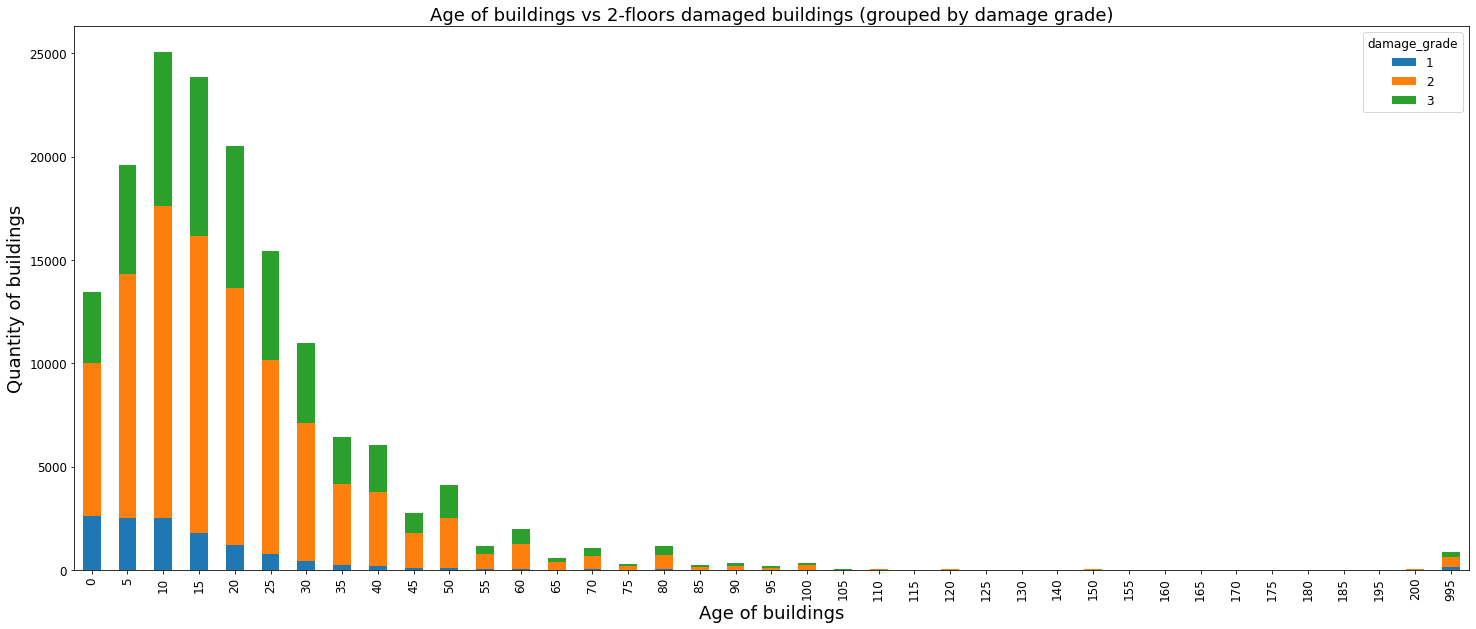

In [137]:
plot_2_floors = damaged_buildings_2_floors_pivot.plot.bar(stacked=True, figsize=(25,10))
plot_2_floors.set_title("Age of buildings vs 2-floors damaged buildings (grouped by damage grade)", fontsize=18)
plot_2_floors.set_ylabel("Quantity of buildings", fontsize=18);
plot_2_floors.set_xlabel("Age of buildings", fontsize=18);

Se observa que se mantiene la relación que los análisis anteriores, donde el mayor daño provocado es de nivel 2, seguido por el nivel 3.

# Condición del suelo